<a href="https://colab.research.google.com/github/wldopie/ESAA/blob/main/HW_221121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **9.6 아이템 기반 최근접 이웃 협업 필터링 실습**

  - 최근접 이웃 협업 필터링
    - `사용자 기반`
    - `아이템 기반`
    - 이 중 일반적으로 `추천 정확도가 더 뛰어난 아이템 기반의 협업 필터링`을 구현해 보자.

  - `협업 필터링 기반의 영화 추천`을 위해서는 사용자가 영화의 평점을 매긴 `사용자-영화 평점 행렬 데이터 세트`가 필요하다. 이를 위해 Grouplens 사이트에서 만든 `MovieLens 데이터 세트`를 이용해 실습해 보자.

---



### **9.6.1 데이터 가공 및 변환**

In [1]:
import pandas as pd
import numpy as np

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


  - `movies.csv`
    - 영화에 대한 메타 정보인 `title`과 `genres`를 가지고 있는 영화 정보
  - `ratings.csv`
    - 사용자별로 영화에 대한 평점을 매긴 데이터 세트
    - 사용자 아이디를 의미하는 `userId`, 영화 아이디를 의미하는 `movieId`, 그리고 평점인 `rating` 칼럼으로 구성

  - ratings.csv의 DataFrame인 ratings를 이용해 아이템 기반의 최근접 이웃 협업 필터링을 구현해 보자.
  - 먼저 로우 레벨 형태의 원본 데이터 세트를 다음 그림과 같이 `모든 사용자를 로우`로, `모든 영화를 칼럼`으로 구성한 데이터 세트로 변경한다.
    - 이는 DataFrame의 `pivot_table()` 함수를 이용하면 쉽게 할 수 있다.

In [2]:
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index = 'userId', columns = 'movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


  - movieId 값이 모두 칼럼 명으로 변환되었다.
  - NaN 값이 많은 이유는 사용자가 평점을 매기지 않은 영화가 칼럼으로 변환되면서 NaN으로 값이 할당됐기 때문이다.
  - 칼럼명이 현재 movieId 숫자 값으로 할당되어 있으므로, 가독성을 높이기 위해 칼럼명을 movieId가 아닌 영화명 title로 변경하자.
  - 이후 NaN은 0으로 변환한다.

In [3]:
# title 칼럼을 얻기 위해 movies와 조인
rating_movies = pd.merge(ratings, movies, on = 'movieId')

# columns = 'title'로 title 칼럼으로 피벗 수행
ratings_matrix = rating_movies.pivot_table('rating', index = 'userId', columns = 'title')

# NaN 값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **9.6.2 영화 간 유사도 산출**

  - 이제 변환된 사용자-영화 평점 행렬 데이터 세트를 이용해 `영화 간의 유사도를 측정`해 보자.
  - 영화 간의 유사도는 `코사인 유사도`를 기반으로 하고, 사이킷런의 `cosine_similarity()`를 이용해 측정한다.
  - 지금 만든 ratings_matrix 데이터 세트에 cosine_similarity()를 적용하면 영화 간 유사도를 측정할 수 없다. 
    - `cosine_similarity()` 함수는 `행을 기준으로 서로 다른 행을 비교`해 유사도를 산출하는데, rating_matrix는 userId가 기준인 행 레벨 데이터이므로 여기에 cosine_similarity()를 적용하면 영화 간의 유사도가 아닌 사용자 간의 유사도가 만들어진다.
    - 따라서, `영화를 기준으로 cosine_similarity()를 적용`하려면 현재의 ratings_matrix가 `행 기준이 영화`가 되고 `열 기준이 사용자`가 되어야 한다.
    - 그러기 위해 ratings_matrix에 `transpose()를 적용`해 행과 열을 서로 바꾼 새로운 행렬을 만들어 보자.

In [4]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  - ratings_matrix를 전치 행렬 형식으로 변경한 데이터 세트를 기반으로 영화의 코사인 유사도를 구해보자.
  - 좀 더 직관적인 영화 유사도 값을 표현하기 위해 `cosine_similarity()로 반환된 넘파이 행렬`에 `영화명을 매핑`해 `DataFrame으로 변환`한다.

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity()로 반환된 넘파이 행렬을 영화명을 매핑해 DataFrame으로 변환
item_sim_df = pd.DataFrame(data = item_sim, index = ratings_matrix.columns,
                           columns = ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


  - 9719 x 9719 shape으로 영화의 유사도 행렬인 item_sim이 생성되었다.
  - item_sim을 DataFrame으로 변환한 뒤, 영화 '대부'와 유사도가 높은 상위 6개 영화를 추출해 보자.

In [6]:
item_sim_df['Godfather, The (1972)'].sort_values(ascending = False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

  - 기준 영화인 '대부'를 제외하면 '대부-2편'이 가장 유사도가 높다.
  - `앞의 콘텐츠 기반 필터링과 다른 점`은 `장르가 완전히 다른 영화도 유사도가 매우 높게` 나타났다는 것이다. 
  - 이번에는 다른 훌륭한 영화인 '인셉션'과 유사도가 높은 영화를 찾아보자.

In [7]:
item_sim_df['Inception (2010)'].sort_values(ascending = False)[1:6]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

  - '다크나이트'가 가장 유사도가 높고, 그 뒤를 이어 주로 스릴러와 액션이 가미된 좋은 영화가 높은 유사도를 나타내고 있다.
  - 만들어진 아이템 기반 유사도 데이터는 사용자의 평점 정보를 모두 취합해 영화에 따라 유사한 다른 영화를 추천할 수 있게 해준다.
  - 이번에는 이 아이템 기반 유사도 데이터를 이용해 개인에게 특화된 영화 추천 알고리즘을 만들어 보자.

### **9.6.3 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천**

  - 앞 예제에서는 모든 사용자의 평점을 기준으로 영화의 유사도를 생성했고, 이를 이용해 훌륭한 영화를 추천할 수 있었다.
  - 하지만 이는 개인적인 취향을 반영하지 않고 영화 간의 유사도만을 가지고 추천한 것이다.
  - 이번 절에서는 `영화 유사도 데이터`를 이용해 `최근접 이웃 협업 필터링`으로 `개인에게 최적화된 영화 추천`을 구현해 보자.

  - `개인화된 영화 추천`의 가장 큰 특징
    - 개인이 `아직 관람하지 않은 영화 추천`을 구현
    - `아직 관람하지 않은 영화`에 대해서 `아이템 유사도`와 `기존에 관람한 영화의 평점` 데이터를 기반으로 해 `새롭게 모든 영화의 예측 평점을 계산`한 후, `높은 예측 평점을 가진 영화를 추천`하는 방식
    - 이러한 아이템 기반의 협업 필터링에서 개인화된 예측 평점은 다음 식으로 구할 수 있습니다.

    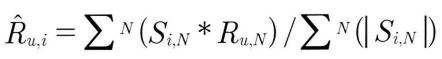

  - 식에 있는 변수의 의미는 다음과 같다.

  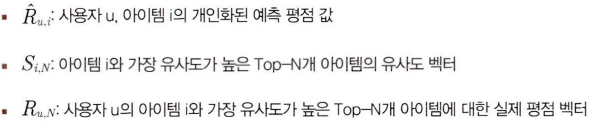


  - 여기에서 N 값은 아이템의 최근접 이웃 범위 계수를 의미한다. 이는 특정 아이템과 유사도가 가장 높은 Top-N개의 다른 아이템을 추출하는 데 사용된다.

  - 먼저 N의 범위에 제약을 두지 않고 모든 아이템으로 가정하고 예측 평점을 구하는 로직을 작성한 뒤, Top-N 아이템을 기반으로 협업 필터링을 수행하는 로직으로 변경해 보자.

  - 앞 예제에서 생성된 `영화 간의 유사도`를 가지는 DataFrame인 `item_sim_df`와 `사용자-영화 평점` DataFrame인 `ratings_matrix` 변수를 계속 활용해 `사용자별로 최적화된 평점 스코어를 예측`하는 함수 `predict_rating()`을 만들어 보자.
    - `인자`로 `사용자-영화 평점 넘파이 행렬`과 `영화 간의 유사도를 가지는 넘파이 행렬`을 입력 받고 이를 이용해 위의 식으로 `개인화된 예측 평점을 계산`한다.

In [8]:
def predict_rating(ratings_arr, item_sim_arr):
  ratings_pred = ratings_arr.dot(item_sim_arr) / np.array([np.abs(item_sim_arr).sum(axis = 1)])
  return ratings_pred

  - predict_rating() 함수를 이용해 개인화된 예측 평점을 구해보자.

In [11]:
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data = ratings_pred, index = ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


  - 예측 평점이 사용자별 영화의 실제 평점과 영화의 코사인 유사도를 내적한 값이기 때문에, 기존에 영화를 관람하지 않아 0에 해당했던 실제 영화 평점이 예측에서는 값이 부여되는 경우가 많이 발생한다.
  - 예측 평점이 실제 평점에 비해 작을 수 있는데, 이는 내적 결과를 코사인 유사도 벡터 합으로 나누었기 때문에 생기는 현상이다.
  - 이 예측 결과가 원래의 실제 평점과 얼마나 차이가 있는지 알아보자.
  - 실제와 예측 평점의 차이는 기존에 평점이 부여된 데이터에 대해서만 오차 정도를 측정한다.

In [12]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE를 구함
def get_mse(pred, actual):
  # 평점이 있는 실제 영화만 추출
  pred = pred[actual.nonzero()].flatten()
  actual = actual[actual.nonzero()].flatten()
  return mean_squared_error(pred, actual)

print('아이템 기반 모든 최근접 이웃 MSE:', get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 모든 최근접 이웃 MSE: 9.895354759094706


  - MSE를 감소시키는 방향으로 개선시켜보자.

  - 앞의 `predict_rating()` 함수는 사용자별 영화의 예측 평점을 계산하기 위해 `해당 영화와 다른 모든 영화 간의 유사도 벡터`를 적용한 것이다. 
  - 이번에는 `특정 영화와 가장 비슷한 유사도를 가지는 영화`에 대해서만 `유사도 벡터를 적용`하는 함수로 변경한다.
    - TOP-N 유사도를 가지는 영화 유사도 벡터의 예측값을 계산하기 위해서는 개별 예측값을 구하기 위해 행, 열 별로 for 루프를 반복 수행하면서 TOP-N 유사도 벡터를 계산해야 해서 수행 시간이 오래 걸린다는 점이다.

In [13]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n = 20):
  # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
  pred = np.zeros(ratings_arr.shape)

  # 사용자-아이템 평점 행렬의 열 크기만큼 루프 수행
  for col in range(ratings_arr.shape[1]):
    # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 반환
    top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
    # 개인화된 예측 평점을 계산
    for row in range(ratings_arr.shape[0]):
      pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)
      pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))

  return pred

  - predict_rating_topsim() 함수를 이용해 예측 평점을 계산하고, 실제 평점과의 MSE를 구해 보자.

In [14]:
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n = 20)
print('아이템 기반 최근접 TOP-20 이웃 MSE:', get_mse(ratings_pred, ratings_matrix.values))

# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data = ratings_pred, index = ratings_matrix.index,
                                   columns = ratings_matrix.columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':


아이템 기반 최근접 TOP-20 이웃 MSE: 3.6949827608772314


  - MSE가 약 3.69로 기존의 9.89보다 많이 향상되었다.
  - 이제 특정 사용자에 대해 영화를 추천해 보자.

In [15]:
user_rating_id = ratings_matrix.loc[9, :]
user_rating_id[ user_rating_id > 0].sort_values(ascending = False)[:10]

title
Adaptation (2002)                                                                 5.0
Citizen Kane (1941)                                                               5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Producers, The (1968)                                                             5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Back to the Future (1985)                                                         5.0
Austin Powers in Goldmember (2002)                                                5.0
Minority Report (2002)                                                            4.0
Witness (1985)                                                                    4.0
Name: 9, dtype: float64

  - 전반적으로 흥행성이 좋은 영화에 높은 평점을 주고 있다.
  - 이 사용자에게 아이템 기반 협업 필터링을 통해 영화를 추천해 보자.
  - 먼저 사용자가 이미 평점을 준 영화를 제외하고 추천할 수 있도록 평점을 주지 않은 영화를 객체로 반환하는 함수인 get_unseen_movies()를 생성한다.

In [16]:
def get_unseen_movies(ratings_matrix, userId):
  # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환
  # 반환된 user_rating은 영화명(title)을 인덱스로 가지는 Series 객체
  user_rating = ratings_matrix.loc[userId, :]

  # user_rating이 0보다 크면 기존에 관람한 영화, 대상 인덱스를 추출해 list 객체로 만듦
  already_seen = user_rating[ user_rating > 0].index.tolist()

  # 모든 영화명을 list 객체로 만듦
  movies_list = ratings_matrix.columns.tolist()

  # list comprehension으로 already_seen에 해당하는 영화는 movies_list에서 제외함
  unseen_list = [ movie for movie in movies_list if movie not in already_seen ]

  return unseen_list

  - 사용자가 `영화의 평점을 주지 않은 추천 대상 영화` 정보와 `predict_rating_topsim()`에서 추출한 `사용자별 아이템 유사도에 기반한 예측 평점 데이터`를 이용해 `최종적으로 사용자에게 영화를 추천`하는 함수인 `recomm_movie_by_userid()`를 만들어 보자.

In [17]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n = 10):
  # 예측 평점 DataFrame에서 사용자id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해
  # 가장 예측 평점이 높은 순으로 정렬
  recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending = False)[:top_n]
  return recomm_movies

# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 최근접 이웃 협업 필터링으로 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n = 10)

# 평점 데이터를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data = recomm_movies.values, index = recomm_movies.index,
                             columns = ['pred_score'])

recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


  - 슈렉, 스파이더 맨, 인디아나 존스-2편, 매트릭스 등 다양하지만 높은 흥행성을 가진 작품이 추천됐다. 

---

## **9.7 행렬 분해를 이용한 잠재 요인 협업 필터링 실습**

---



  - 이번에는 행렬 분해를 이용한 잠재 요인 협업 필터링을 직접 구현해 보자.
  - 일반적으로 행렬 분해에는 SVD가 자주 사용되나, 사용자-아이템 평점 행렬에는 사용자가 평점을 매기지 않은 널 데이터가 많기 때문에 주로 SGD나 ALS 기반의 행렬 분해를 이용한다. 
  - 따라서 여기서는 SGD 기반의 행렬 분해를 구현하고, 이를 기반으로 사용자에게 영화를 추천해 보자.

In [25]:
import numpy as np
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
      
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse

In [26]:
def matrix_factorization(R, K, steps = 200, learning_rate = 0.01, r_lambda = 0.01):
  num_users, num_items = R.shape
  # P와 Q 매트릭스의 크기를 지정하고 정규 분포를 가진 랜덤한 값으로 입력한다.
  np.random.seed(1)
  P = np.random.normal(scale = 1./K, size = (num_users, K))
  Q = np.random.normal(scale = 1./K, size = (num_items, K))

  prev_rmse = 10000
  break_count = 0

  # R > 0인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장
  non_zeros = [ (i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j] > 0]

  # SGD 기법으로 P와 Q 매트릭스를 계속 업데이트
  for step in range(steps):
    for i, j, r in non_zeros:
      # 실제 값과 예측 값의 차이인 오류 값 구함
      eij = r - np.dot(P[i, :], Q[j, :].T)
      # Regularization을 반영한 SGD 업데이트 공식 적용
      P[i, :] = P[i, :] + learning_rate * (eij * Q[j, :] - r_lambda * P[i, :])
      Q[j, :] = Q[j, :] + learning_rate * (eij * P[i, :] - r_lambda * Q[j, :])

    rmse = get_rmse(R, P, Q, non_zeros)
    if (step % 10) == 0:
      print('### iteration step :', step, 'rmse :', rmse)

  return P, Q

  - 먼저 영화 평점 행렬 데이터를 새롭게 DataFrame으로 로딩한 뒤에 다시 사용자-아이템 평점 행렬로 만들자.

In [27]:
import pandas as pd
import numpy as np

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index = 'userId', columns = 'movieId')

# title 칼럼을 얻기 위해 movies와 조인 수행
ratings_movies = pd.merge(ratings, movies, on = 'movieId')

# columns = 'title'로 title 칼럼으로 pivot 수행
ratings_matrix = ratings_movies.pivot_table('rating', index = 'userId', columns = 'title')

  - 다시 만들어진 사용자-아이템 평점 행렬을 matrix_factorization() 함수를 이용해 행렬 분해해보자.

In [28]:
P, Q = matrix_factorization(ratings_matrix.values, K = 50, steps = 200, learning_rate = 0.01,
                            r_lambda = 0.01)

pred_matrix = np.dot(P, Q.T)

### iteration step : 0 rmse : 2.9023619751336867
### iteration step : 10 rmse : 0.7335768591017927
### iteration step : 20 rmse : 0.5115539026853442
### iteration step : 30 rmse : 0.37261628282537446
### iteration step : 40 rmse : 0.2960818299181014
### iteration step : 50 rmse : 0.2520353192341642
### iteration step : 60 rmse : 0.22487503275269854
### iteration step : 70 rmse : 0.2068545530233154
### iteration step : 80 rmse : 0.19413418783028685
### iteration step : 90 rmse : 0.18470082002720403
### iteration step : 100 rmse : 0.17742927527209104
### iteration step : 110 rmse : 0.17165226964707492
### iteration step : 120 rmse : 0.16695181946871723
### iteration step : 130 rmse : 0.16305292191997545
### iteration step : 140 rmse : 0.15976691929679646
### iteration step : 150 rmse : 0.1569598699945732
### iteration step : 160 rmse : 0.1545339818671543
### iteration step : 170 rmse : 0.15241618551077643
### iteration step : 180 rmse : 0.1505508073962831
### iteration step : 190 rmse : 

  - 더 쉽게 영화 아이템 칼럼을 이해하기 위해 반환된 예측 사용자-아이템 평점 행렬을 영화 타이틀을 칼럼명으로 가지는 DataFrame으로 변경해 보자.

In [ ]:
ratings_pred_matrix = pd.DataFrame(data = pred_matrix, index = ratings_matrix.index,
                                   columns = ratings_matrix.columns)

ratings_pred_matrix.head(3)

  - 이렇게 만들어진 예측 사용자-아이템 평점 행렬 정보를 이용해 개인화된 영화 추천을 해 보자. 

In [29]:
# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 잠재 요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n = 10)

# 평점 데이터를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data = recomm_movies.values, index = recomm_movies.index,
                             columns = ['pred_score'])

recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591
